<h1>Performing Hamiltonian Simulation with QSP-Generated Quantum Circuit</h1>

<h2> Distribution Statement </h2>

DISTRIBUTION STATEMENT A. Approved for public release. Distribution is unlimited.

<br>
This material is based upon work supported by the Under Secretary of Defense for
Research and Engineering under Air Force Contract No. FA8702-15-D-0001. Any opinions,
findings, conclusions or recommendations expressed in this material are those of the
author(s) and do not necessarily reflect the views of the Under Secretary of Defense
for Research and Engineering.

<br>
© 2022 Massachusetts Institute of Technology.

<br>
<br>
The software/firmware is provided to you on an As-Is basis

<br>
<br>
Delivered to the U.S. Government with Unlimited Rights, as defined in DFARS Part
252.227-7013 or 7014 (Feb 2014). Notwithstanding any copyright notice, U.S. Government
rights in this work are defined by DFARS 252.227-7013 or DFARS 252.227-7014 as detailed
above. Use of this work other than as specifically authorized by the U.S. Government
may violate any copyrights that exist in this work.

This notebook describes how to perform Hamiltonian simulation with a Quantum Signal Processing (QSP) generated quantum circuit. To confirm that the quantum circuit is performing the simulation to the requested precision, the results are compared to those of a classical approach.

For this notebook a Hamiltonain derived from the Vlasov Equation is used. For more information on framing the Vlasov equation as a quantum algorithms problem please see accompanying notebooks.

In [1]:
### 
### Publicly Available Libraries:
###
import sys
import os
import cirq
import numpy             as np
import numpy.linalg      as la
import scipy.integrate   as spi
import matplotlib.pyplot as plt
import time


###
### Imports to support the pyQSP Gate-Based simulation
###
from pyLIQTR.QSP import gen_qsp                 as qspFuncs
from pyLIQTR.QSP import QSP                     as pQSP
from pyLIQTR.QSP.Hamiltonian import Hamiltonian as pyH

from pyLIQTR.QSP.gen_qsp import QSP_Simulator
from pyLIQTR.QSP.qsp_helpers import get_state_vector, time_step_comparison_mpe

###
### Imports to support classical simulation of Vlasov-Poisson 
###
# sys.path.append('..')
 #sys.path.append(os.path.join('..','model_simulators'))

import pyLIQTR.model_simulators.vlasovsim as vs        
np.set_printoptions(precision=2)


<h2>General Problem Setup </h2>

Begin by defining the Hamiltonian for the problem, as well as the relevant timestep and simulation time.

In [2]:
###
### User Input: Vlasov Equation Parameterization 
###

N      =  3                                    # Number of terms in the Vlasov-Hermite 
                                               # expansion (equivalent to qubits)

k      =  2.0                                  # Fourier wavenumber

nu     =  0.0                                  # Collisional damping parameter : 
                                               # (for use only with statevector propagation)
                                               # (SET TO 0 for now, since imag otherwise)

alpha  =  0.6                                  # Electric field parameter

###
### User Input: Simulation Time Parameterization
###

dt           =  0.1                           # Integration timestep
tmax         =  5                             # Maximal timestep
sclf         =  1                              # Scale factor for timestep sampling
Ns           =  int(np.ceil(tmax/dt))          # Total number of timesteps
timestep_vec = np.arange(0,tmax+dt,sclf*dt)    # Define array of timesteps

###
### User Input: Required Simulation Precision
###

required_precision = 1e-2

#Define the initial state. For this example only occupy the first qubit
occ_state = np.zeros(N)
occ_state[0] = 1
print(':--------------------------------------------------')
print(f': Initial qubit occ_state projections: {occ_state}')

:--------------------------------------------------
: Initial qubit occ_state projections: [1. 0. 0.]


<h2> Gate-based QSP Simulation </h2>

Define QSP Hamiltonian and calculate QSP angles. QSP angles take ~6 minutes to generate with default notebook parameters, and ~9 seconds to recall from cache if they've been previously generated.


Please note, calculating angles generates signifigant output to screen.

In [ ]:
ham_strings = vs.hamiltonian_wfn_vlasov_hermite_linear_sym_string(k,alpha,nu,N)
qsp_H       = pyH(ham_strings)

tmp = [qspFuncs.get_phis(qsp_H, simtime=t, req_prec=required_precision) for t in timestep_vec]


tolerances   = [a[1] for a in tmp]
angles       = [a[0] for a in tmp]

Define the inital state circuit

In [4]:
qsp_generator = pQSP.QSP(phis=angles[1], hamiltonian=qsp_H, target_size=qsp_H.problem_size)

initial_state_circuit = cirq.Circuit()

# Establish qubit occupancy for inital state of circuit
for idx,state in enumerate(occ_state[::-1]):
    if state == 1:
        initial_state_circuit.append(cirq.X.on(qsp_generator.target[idx]))
    else:
        initial_state_circuit.append(cirq.I.on(qsp_generator.target[idx]))

Perform the QSP Simulation. Please note, with the default notebook parameters this cell takes approximately 12 minutes to run.

In [5]:
qsp_sim = QSP_Simulator(
    timestep_vec = timestep_vec,
    angles       = angles,
    init_state   = initial_state_circuit,
    qsp_H        = qsp_H)

sim_results = qsp_sim.do_sim()

def measure_obs_cirq(state,obs=vs.przp):
    state = get_state_vector(state,lsb_first=False)
    exp = np.real(vs.measure_obs_site(state[::-1], obs))[-N:]
    return exp

observables = []
for rslt in sim_results:
    observables.append(measure_obs_cirq(rslt)) 

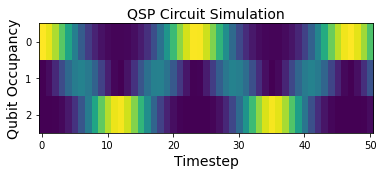

In [6]:
###
### Plot qubit population over time
###

#plt.figure(figsize=(5,5), dpi=300)
plt.imshow(np.transpose(np.real(observables)),cmap='viridis', interpolation='nearest',
                        aspect=Ns/(3*N))
plt.xlabel('Timestep',fontsize=14)
plt.ylabel('Qubit Occupancy',fontsize=14)
plt.title('QSP Circuit Simulation',fontsize=14)
plt.show()

<h2>Direct Classical Simulation </h2>

Construct the classical representation of the wavefunction 

In [7]:
# Initialize the wavefunction
wfn = 0j

for j in range(N):
    if (occ_state[j] == 1):
        wfn += vs.state_multifermi_idx((j,),N)

wfn  = wfn / la.norm(wfn)
wfnp = vs.vectorize_cvec(wfn)

Perform the simulation and plot the projections for each timestep

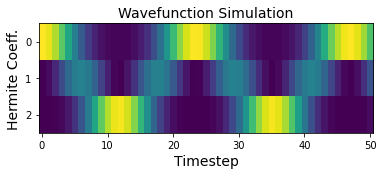

In [8]:
# hamiltonian for this simulation
HP            = vs.hamiltonian_wfn_vlasov_hermite_linear_sym(k,alpha,nu,N)

traj_raw_wfn  = spi.odeint(vs.prop_wfn,wfnp,timestep_vec,args=(HP,))
traj_proc_wfn = vs.parse_wfn_trajz_pzpj(timestep_vec,traj_raw_wfn)


# Visualize the projection over time:
#plt.figure(figsize=(5,5), dpi=300)
plt.imshow(np.transpose(traj_proc_wfn[:,1:(N+1)].real),cmap='viridis', interpolation='nearest',
                        aspect=Ns/(3*N))
plt.xlabel('Timestep',fontsize=14)
plt.ylabel('Hermite Coeff.',fontsize=14)
plt.title('Wavefunction Simulation',fontsize=14)
plt.show()


<h2> Perform a comparison </h2>

(1e-06, 10)

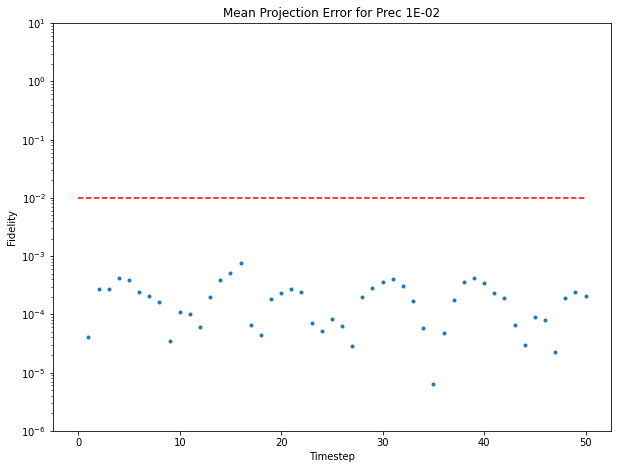

In [9]:
classical  = traj_proc_wfn[:,-N:].real
gate_based = observables 
mpe        = time_step_comparison_mpe(classical, gate_based)

epsilon    = required_precision*np.ones(len(gate_based))

#plt.figure(figsize=(10/2, 7.5/2), dpi=300)
plt.figure(figsize=(10, 7.5))
plt.plot(mpe, '.')
plt.plot(epsilon, 'r--')
plt.title(f'Mean Projection Error for Prec {required_precision:.0E}')
plt.xlabel('Timestep')
plt.ylabel('Fidelity')
plt.yscale('log')
plt.ylim([10e-7, 10])
